In [57]:
!pip install tensorflow

In [58]:
!pip install matplotlib

In [59]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [60]:
import os
os.chdir('/kaggle/input/landslide4sense')

In [61]:
# Testing the dataset 
path_single = "/kaggle/input/landslide4sense/TrainData/img/image_1.h5"
path_single_mask = '/kaggle/input/landslide4sense/TrainData/mask/mask_1.h5'

ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


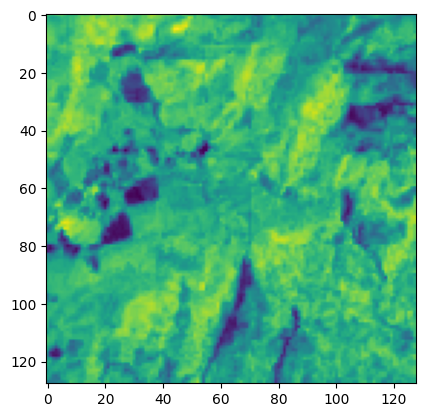

In [62]:
# Create a 4D NumPy array initialized with zeros to store features (1 image, 128x128 size, 3 channels)
f_data = np.zeros((1, 128, 128, 3))

# Open the HDF5 file located at 'path_single'
with h5py.File(path_single) as hdf:
    
    # Get a list of the keys (datasets) in the HDF5 file
    ls = list(hdf.keys())
    print("ls", ls)
    
    # Load the dataset named 'img' from the HDF5 file into a NumPy array
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    
    # Display the RGB image using matplotlib (reverses channels 3,2,1 for RGB)
    plt.imshow(data[:, :, 3:0:-1])
    
    # Extract the red band (channel 3)
    data_red = data[:, :, 3]
    
    # Extract the green band (channel 2)
    data_green = data[:, :, 2]
    
    # Extract the blue band (channel 1)
    data_blue = data[:, :, 1]
    
    # Extract the near-infrared (NIR) band (channel 7)
    data_nir = data[:, :, 7]
    
    # Extract RGB image data (channels 3 to 1, reversed to RGB order)
    data_rgb = data[:, :, 3:0:-1]
    
    # Calculate NDVI (Normalized Difference Vegetation Index)
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))
    
    # Store NDVI in the first channel of f_data
    f_data[0, :, :, 0] = data_ndvi
    
    # Store slope data (assumed to be in channel 12) in the second channel of f_data
    f_data[0, :, :, 1] = data[:, :, 12]
    
    # Store elevation data (assumed to be in channel 13) in the third channel of f_data
    f_data[0, :, :, 2] = data[:, :, 13]


    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


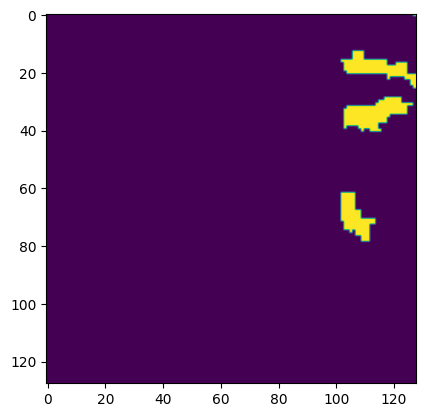

In [63]:
# Open the HDF5 file located at 'path_single_mask'
with h5py.File(path_single_mask) as hdf:
    
    # Get a list of the keys (datasets) present in the HDF5 file
    ls = list(hdf.keys())
    print("ls", ls)
    
    # Load the dataset named 'mask' from the HDF5 file into a NumPy array
    data = np.array(hdf.get('mask'))
    
    # Print the shape of the loaded mask data
    print("input data shape:", data.shape)
    
    # Display the mask image using matplotlib (grayscale by default)
    plt.imshow(data)


In [64]:
# Path to a single training image HDF5 file
path_single = "/kaggle/input/landslide4sense/TrainData/img/image_1.h5"

# Path to the corresponding mask HDF5 file
path_single_mask = "/kaggle/input/landslide4sense/TrainData/mask/mask_1.h5"

# Glob pattern to match all training image HDF5 files
TRAIN_PATH = "/kaggle/input/landslide4sense/TrainData/img/*.h5"

# Glob pattern to match all corresponding mask HDF5 files
TRAIN_MASK = "/kaggle/input/landslide4sense/TrainData/mask/*.h5"

# Initialize an array to hold training data features for all 3799 samples
# Shape: (number of samples, height, width, number of channels/features)
# Here, 6 channels could include NDVI, slope, elevation, RGB, etc.
TRAIN_XX = np.zeros((3799, 128, 128, 6))

# Initialize an array to hold corresponding ground truth mask labels
# Shape: (number of samples, height, width, 1 channel for binary mask)
TRAIN_YY = np.zeros((3799, 128, 128, 1))

# Get sorted list of all image HDF5 file paths
all_train = sorted(glob.glob(TRAIN_PATH))

# Get sorted list of all mask HDF5 file paths
all_mask = sorted(glob.glob(TRAIN_MASK))


In [65]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [66]:
# Loop over all image and mask file paths with an index
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    
    # Print index and file paths for debugging/tracking
    print(i, img, mask)
    
    # Open the HDF5 image file
    with h5py.File(img) as hdf:
        
        # List the datasets in the HDF5 file (usually just 'img')
        ls = list(hdf.keys())
        
        # Load the 'img' dataset as a NumPy array
        data = np.array(hdf.get('img'))

        # Replace any NaN values with a small number to avoid errors during calculations
        data[np.isnan(data)] = 0.000001

        # Normalize RGB channels using max value / 2 as the midpoint
        mid_rgb = data[:, :, 1:4].max() / 2.0  # channels 1=Blue, 2=Green, 3=Red

        # Normalize slope (assumed to be in channel 12)
        mid_slope = data[:, :, 12].max() / 2.0

        # Normalize elevation (assumed to be in channel 13)
        mid_elevation = data[:, :, 13].max() / 2.0

        # Extract red (channel 3) and NIR (channel 7) for NDVI calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]

        # Compute NDVI = (NIR - RED) / (NIR + RED)
        data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))

        # Fill training data array with normalized and computed features:
        
        # Channel 0: Normalized Red (inverted)
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb
        
        # Channel 1: Normalized Green (inverted)
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb
        
        # Channel 2: Normalized Blue (inverted)
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb
        
        # Channel 3: NDVI (vegetation index)
        TRAIN_XX[i, :, :, 3] = data_ndvi
        
        # Channel 4: Normalized Slope (inverted)
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope
        
        # Channel 5: Normalized Elevation (inverted)
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation

    # Open the corresponding HDF5 mask file
    with h5py.File(mask) as hdf:
        
        # List the datasets (should contain 'mask')
        ls = list(hdf.keys())
        
        # Load the mask as a NumPy array
        data = np.array(hdf.get('mask'))
        
        # Store the mask in the training label array
        TRAIN_YY[i, :, :, 0] = data


0 /kaggle/input/landslide4sense/TrainData/img/image_1.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1.h5
1 /kaggle/input/landslide4sense/TrainData/img/image_10.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_10.h5
2 /kaggle/input/landslide4sense/TrainData/img/image_100.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_100.h5
3 /kaggle/input/landslide4sense/TrainData/img/image_1000.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1000.h5
4 /kaggle/input/landslide4sense/TrainData/img/image_1001.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1001.h5
5 /kaggle/input/landslide4sense/TrainData/img/image_1002.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1002.h5
6 /kaggle/input/landslide4sense/TrainData/img/image_1003.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1003.h5
7 /kaggle/input/landslide4sense/TrainData/img/image_1004.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1004.h5
8 /kaggle/input/landslide4sense/TrainData/img/image_1005.h5 /kaggle/

<ipython-input-66-26974749d3df>:50: RuntimeWarning: invalid value encountered in divide
  TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope


1675 /kaggle/input/landslide4sense/TrainData/img/image_2506.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2506.h5
1676 /kaggle/input/landslide4sense/TrainData/img/image_2507.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2507.h5
1677 /kaggle/input/landslide4sense/TrainData/img/image_2508.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2508.h5
1678 /kaggle/input/landslide4sense/TrainData/img/image_2509.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2509.h5
1679 /kaggle/input/landslide4sense/TrainData/img/image_251.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_251.h5
1680 /kaggle/input/landslide4sense/TrainData/img/image_2510.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2510.h5
1681 /kaggle/input/landslide4sense/TrainData/img/image_2511.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2511.h5
1682 /kaggle/input/landslide4sense/TrainData/img/image_2512.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2512.h5
1683 /kaggle/input/landslide4sense

<ipython-input-66-26974749d3df>:33: RuntimeWarning: divide by zero encountered in divide
  data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))
<ipython-input-66-26974749d3df>:33: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))


2267 /kaggle/input/landslide4sense/TrainData/img/image_3039.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3039.h5
2268 /kaggle/input/landslide4sense/TrainData/img/image_304.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_304.h5
2269 /kaggle/input/landslide4sense/TrainData/img/image_3040.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3040.h5
2270 /kaggle/input/landslide4sense/TrainData/img/image_3041.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3041.h5
2271 /kaggle/input/landslide4sense/TrainData/img/image_3042.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3042.h5
2272 /kaggle/input/landslide4sense/TrainData/img/image_3043.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3043.h5
2273 /kaggle/input/landslide4sense/TrainData/img/image_3044.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3044.h5
2274 /kaggle/input/landslide4sense/TrainData/img/image_3045.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3045.h5
2275 /kaggle/input/landslide4sense

In [67]:
# Replace any remaining NaN values in TRAIN_XX with a small number to prevent issues during training
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001

# Print the min and max values of the feature set and the label set to verify range and check for anomalies
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


In [68]:
def dice_loss(y_true, y_pred):
    # Convert the ground truth to float (required for arithmetic ops)
    y_true = tf.cast(y_true, tf.float32)

    # Apply sigmoid activation to the predictions (for binary segmentation output)
    y_pred = tf.math.sigmoid(y_pred)

    # Compute the numerator: 2 * intersection
    numerator = 2 * tf.reduce_sum(y_true * y_pred)

    # Compute the denominator: sum of all predicted and true pixels (union)
    denominator = tf.reduce_sum(y_true + y_pred)

    # Dice Loss = 1 - Dice Coefficient
    return 1 - numerator / denominator


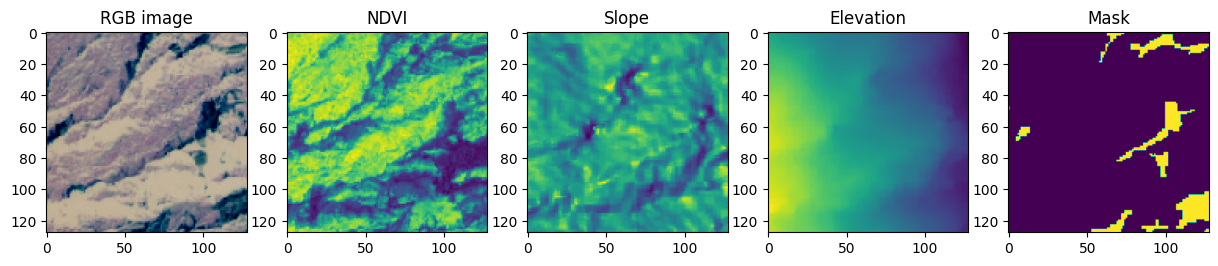

In [69]:
img=234
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_YY[img, :, :, 0])

In [70]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

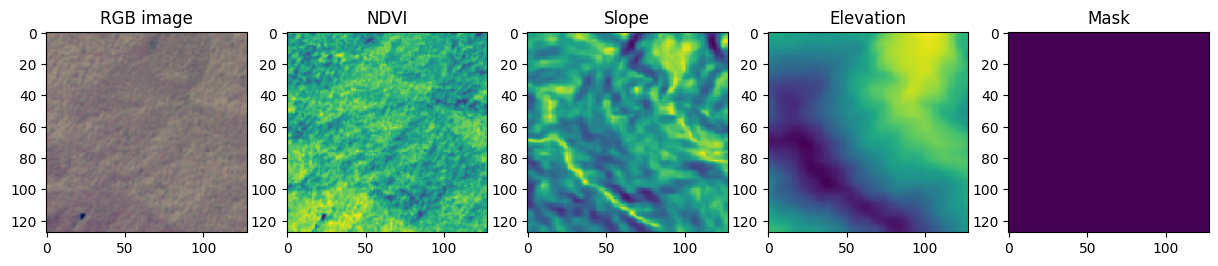

In [71]:
img=155
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(x_train[img, :, :, 5])
ax5.imshow(y_train[img, :, :, 0])

In [72]:
x_train.shape, y_train.shape

((3039, 128, 128, 6), (3039, 128, 128, 1))

In [73]:
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask 

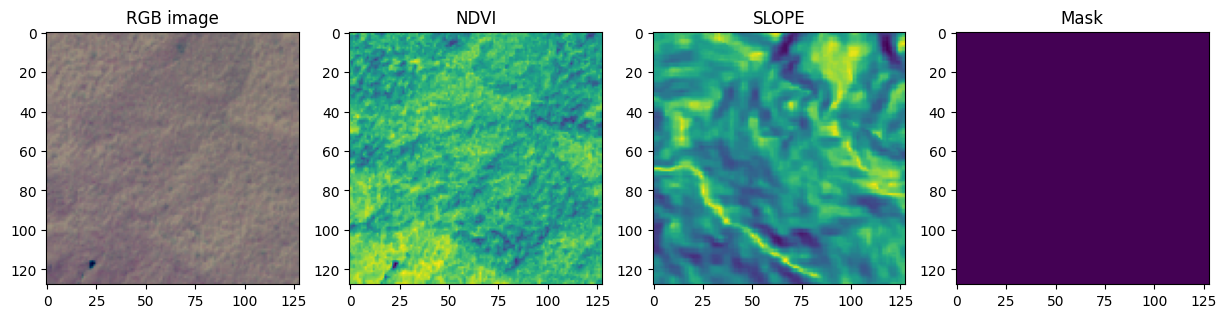

In [74]:
img=155
fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("SLOPE")
ax4.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(y_train[img, :, :, 0])

In [75]:
# Add the utils path so custom metrics can be imported
import sys
sys.path.append("/kaggle/input/utils-file/utils")  

# Import custom evaluation metrics
from utils import recall_m, precision_m, f1_m

# Define a function that builds the U-Net model with given input dimensions
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    # Define input layer with specified shape
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # ---------------------- Contraction (Encoder) Path ---------------------- #

    # Block 1
    # Apply a 2D convolution with 16 filters of size 3x3 to the input image.
    # 'relu' introduces non-linearity, 'he_normal' initializes weights well for ReLU, 'same' keeps output size same as input.
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    #relu - rectified linear unit
    # Dropout layer randomly sets 10% of inputs to zero during training to prevent overfitting.
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    
    # Another convolution layer to extract more complex features from the output of previous layer.
    # Helps the network learn better representations.
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    
    # MaxPooling layer reduces the spatial dimensions by half (downsampling).
    # It keeps the most important features and reduces computation in the next layers.
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


    # Block 2
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    # Block 4
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck (Deepest layer)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # ---------------------- Expansive (Decoder) Path ---------------------- #

    # Up Block 1
    # Transposed Convolution (also called deconvolution or upsampling) to increase spatial dimensions by 2x.
    # 128 filters of size 2x2, stride of 2 means it upsamples the feature map (e.g., from 8x8 to 16x16).
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    
    # Concatenate the upsampled feature map (u6) with the corresponding feature map from the encoder path (c4).
    # This skip connection helps retain high-resolution features lost during downsampling.
    u6 = tf.keras.layers.concatenate([u6, c4])
    
    # Apply a convolution layer on the concatenated output to learn features from both upsampled and high-res encoder features.
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    
    # Dropout layer sets 20% of inputs to zero during training to avoid overfitting.
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    
    # Another convolution layer to further process the combined features and refine the upsampled output.
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Up Block 2
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Up Block 3
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Up Block 4
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer with 1 filter and sigmoid activation for binary segmentation
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create the model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    # Compile the model with Adam optimizer, binary crossentropy loss and custom metrics
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
    #Adaptive Moment Estimation
    return model


In [76]:
model = unet_model(128, 128, 6)

# Define ModelCheckpoint to save the best model based on val_f1_m
checkpointer = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")

# Define any additional callbacks (e.g., EarlyStopping)
callbacks = [
    # earlyStopping,
    checkpointer
]

# Train the model
history = model.fit(x_train, y_train, batch_size=16,  
                    epochs=100, 
                    verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=callbacks)

# Save the final model 
model.save("/kaggle/working/model_save.h5")


Epoch 1/100

Epoch 1: val_f1_m improved from -inf to 0.59770, saving model to /kaggle/working/best_model.keras
190/190 - 29s - 153ms/step - accuracy: 0.9764 - f1_m: 0.2212 - loss: 0.0783 - precision_m: 0.5053 - recall_m: 0.1784 - val_accuracy: 0.9819 - val_f1_m: 0.5977 - val_loss: 0.0479 - val_precision_m: 0.6785 - val_recall_m: 0.5397
Epoch 2/100

Epoch 2: val_f1_m did not improve from 0.59770
190/190 - 7s - 39ms/step - accuracy: 0.9833 - f1_m: 0.5617 - loss: 0.0438 - precision_m: 0.6947 - recall_m: 0.4993 - val_accuracy: 0.9820 - val_f1_m: 0.5040 - val_loss: 0.0494 - val_precision_m: 0.8240 - val_recall_m: 0.3680
Epoch 3/100

Epoch 3: val_f1_m improved from 0.59770 to 0.61210, saving model to /kaggle/working/best_model.keras
190/190 - 8s - 40ms/step - accuracy: 0.9852 - f1_m: 0.5976 - loss: 0.0388 - precision_m: 0.7339 - recall_m: 0.5273 - val_accuracy: 0.9841 - val_f1_m: 0.6121 - val_loss: 0.0418 - val_precision_m: 0.7814 - val_recall_m: 0.5084
Epoch 4/100

Epoch 4: val_f1_m did not

In [77]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

0.038878146559000015 0.9866806864738464 0.7023680806159973 0.8111185431480408 0.620902955532074


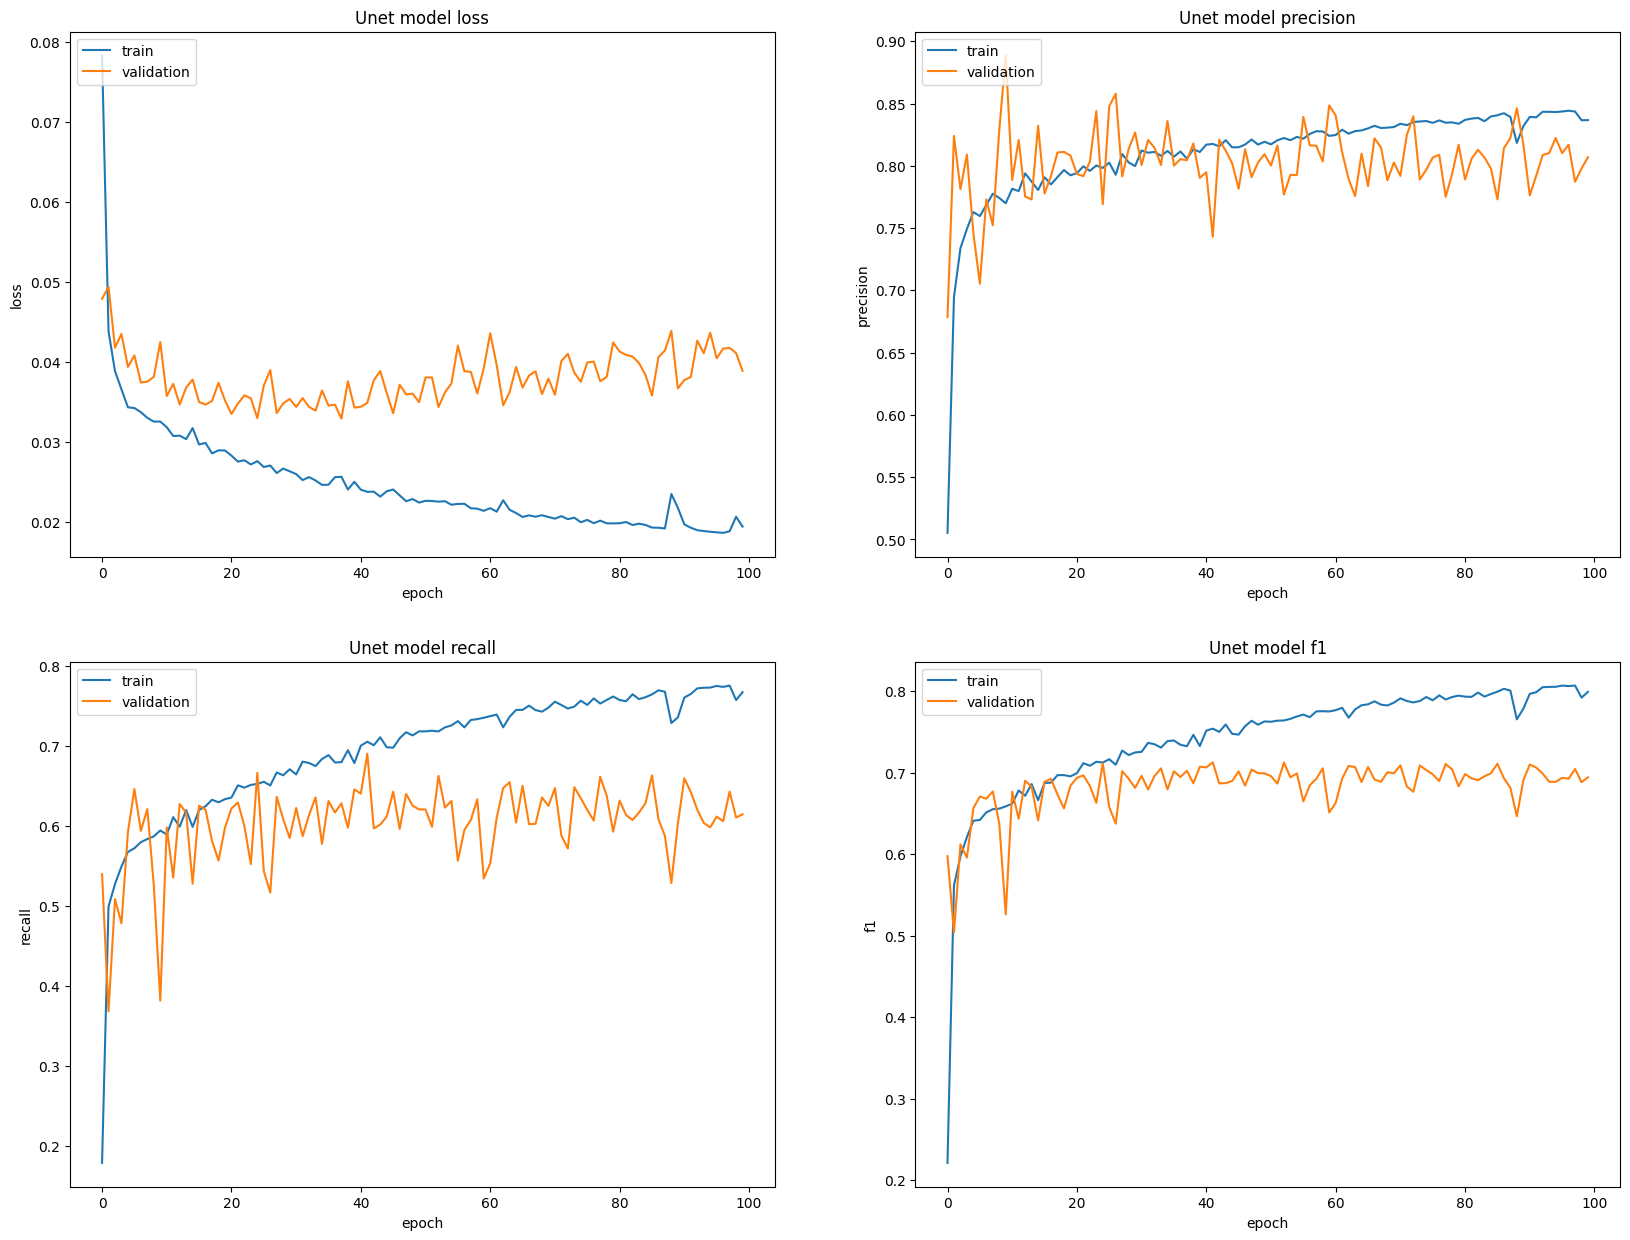

In [78]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [79]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Text(0.5, 1.0, 'Training Image')

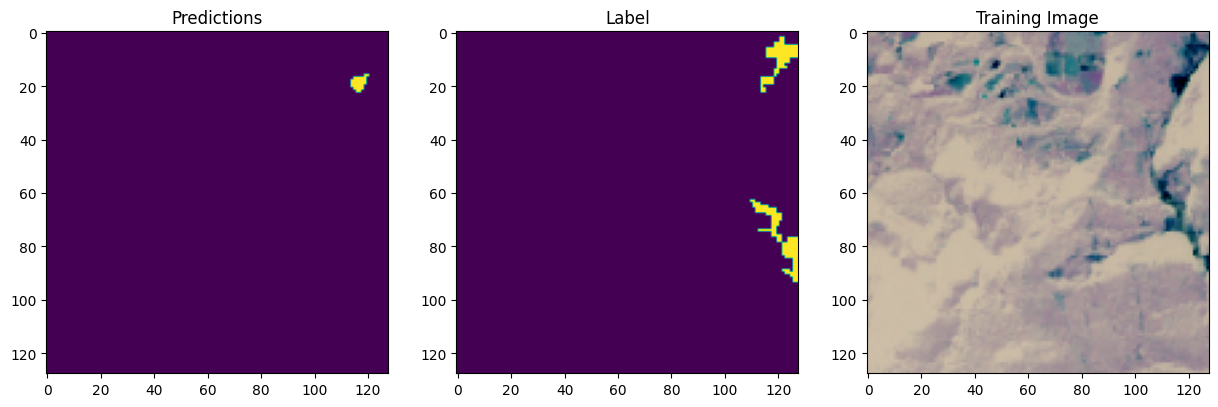

In [80]:
img = 155
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

In [81]:
validation_url = "/kaggle/input/landslide4sense/ValidData/img/*.h5"
img_val = sorted(glob.glob(validation_url))

VAL_XX = np.zeros((245, 128, 128, 6))
mask_name = []
for i, img in enumerate(img_val):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # final array
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        VAL_XX[i, :, :, 3] = data_ndvi #NDVI
        VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

0 /kaggle/input/landslide4sense/ValidData/img/image_1.h5
1 /kaggle/input/landslide4sense/ValidData/img/image_10.h5
2 /kaggle/input/landslide4sense/ValidData/img/image_100.h5
3 /kaggle/input/landslide4sense/ValidData/img/image_101.h5
4 /kaggle/input/landslide4sense/ValidData/img/image_102.h5
5 /kaggle/input/landslide4sense/ValidData/img/image_103.h5
6 /kaggle/input/landslide4sense/ValidData/img/image_104.h5
7 /kaggle/input/landslide4sense/ValidData/img/image_105.h5
8 /kaggle/input/landslide4sense/ValidData/img/image_106.h5
9 /kaggle/input/landslide4sense/ValidData/img/image_107.h5
10 /kaggle/input/landslide4sense/ValidData/img/image_108.h5
11 /kaggle/input/landslide4sense/ValidData/img/image_109.h5
12 /kaggle/input/landslide4sense/ValidData/img/image_11.h5
13 /kaggle/input/landslide4sense/ValidData/img/image_110.h5
14 /kaggle/input/landslide4sense/ValidData/img/image_111.h5
15 /kaggle/input/landslide4sense/ValidData/img/image_112.h5
16 /kaggle/input/landslide4sense/ValidData/img/image_1

<ipython-input-81-ba5fee1be569>:24: RuntimeWarning: divide by zero encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
<ipython-input-81-ba5fee1be569>:24: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


160 /kaggle/input/landslide4sense/ValidData/img/image_243.h5
161 /kaggle/input/landslide4sense/ValidData/img/image_244.h5
162 /kaggle/input/landslide4sense/ValidData/img/image_245.h5
163 /kaggle/input/landslide4sense/ValidData/img/image_25.h5
164 /kaggle/input/landslide4sense/ValidData/img/image_26.h5
165 /kaggle/input/landslide4sense/ValidData/img/image_27.h5
166 /kaggle/input/landslide4sense/ValidData/img/image_28.h5
167 /kaggle/input/landslide4sense/ValidData/img/image_29.h5
168 /kaggle/input/landslide4sense/ValidData/img/image_3.h5
169 /kaggle/input/landslide4sense/ValidData/img/image_30.h5
170 /kaggle/input/landslide4sense/ValidData/img/image_31.h5
171 /kaggle/input/landslide4sense/ValidData/img/image_32.h5
172 /kaggle/input/landslide4sense/ValidData/img/image_33.h5
173 /kaggle/input/landslide4sense/ValidData/img/image_34.h5
174 /kaggle/input/landslide4sense/ValidData/img/image_35.h5
175 /kaggle/input/landslide4sense/ValidData/img/image_36.h5
176 /kaggle/input/landslide4sense/Vali

In [82]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


<ipython-input-82-72ffe7cc9193>:3: RuntimeWarning: invalid value encountered in greater
  pred_img = (pred_img > threshold).astype(np.uint8)


(245, 128, 128, 1)

Accuracy for image 167: 0.9864


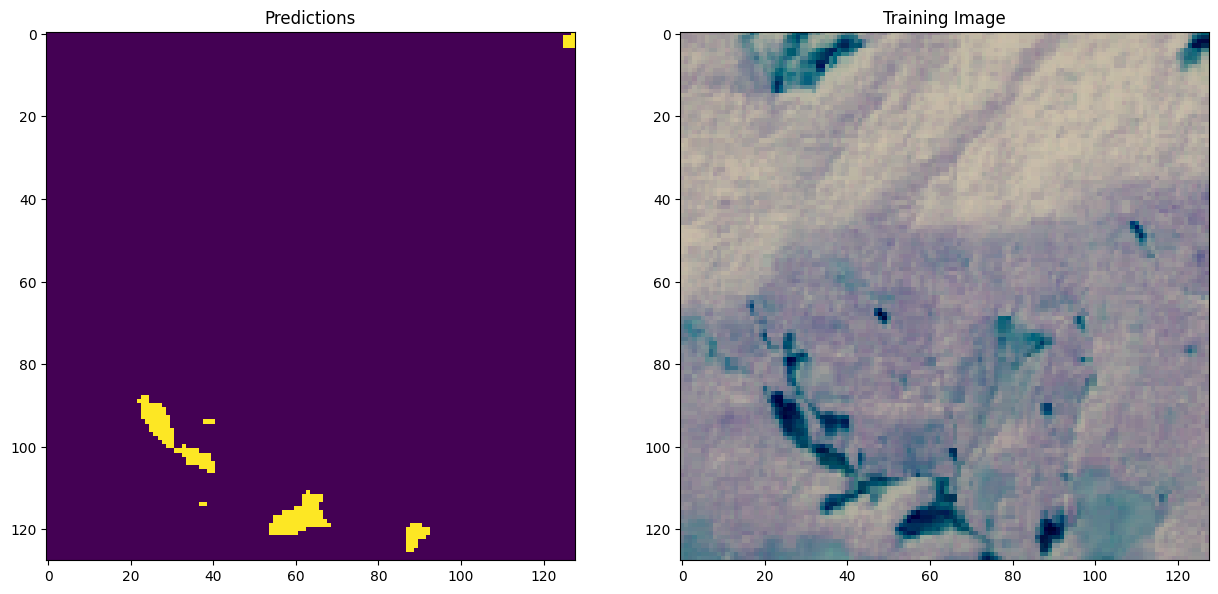

In [84]:
from sklearn.metrics import accuracy_score

img = 167
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')

# Threshold the predicted mask to binary (0 or 1)
pred_mask = (pred_img[img, :, :, 0] > 0.5).astype(int)

# Flatten both prediction and ground truth mask for comparison
true_mask = y_valid[img, :, :, 0].astype(int).flatten()

pred_mask_flat = pred_mask.flatten()

# Calculate accuracy
acc = accuracy_score(true_mask, pred_mask_flat)
print(f"Accuracy for image {img}: {acc:.4f}")


In [85]:
# Evaluate on training data
train_loss, train_acc, train_f1, train_prec, train_recall = model.evaluate(x_train, y_train, verbose=0)

# Evaluate on validation (or test) data
val_loss, val_acc, val_f1, val_prec, val_recall = model.evaluate(x_valid, y_valid, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")


Train Accuracy: 0.9928, F1: 0.8243
Validation Accuracy: 0.9867, F1: 0.7024
